# Project: Bollinger Bands Mean Reversion Strategy

When prices move far from their average (more than a few standard deviations), they tend to revert.
We’ll go long when the price dips below the lower Bollinger Band (oversold) and short when it rises above the upper band (overbought).

We’ll only take Bollinger Band mean reversion signals when the RSI confirms oversold or overbought conditions — improving signal quality and avoiding “catching falling knives.”

## Imports

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime

%load_ext autoreload
%autoreload 2

## Data Setup

In [2]:
ticker = 'AAPL'
start_date = '2015-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

ticker, start_date, end_date

('AAPL', '2015-01-01', '2025-10-27')

In [3]:
df = yf.download(ticker, start=start_date, end=end_date)
df = df.droplevel(axis=1, level=1)['Close'].to_frame()
df.dropna(inplace=True)
df.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


,Close
Date,
2015-01-02,24.261049
2015-01-05,23.577572
2015-01-06,23.579796
2015-01-07,23.910429
2015-01-08,24.829130


## Set Indicators

In [4]:
window = 20
num_std = 2
rsi_period = 14

In [5]:
df

,Close
Date,
2015-01-02,24.261049
2015-01-05,23.577572
2015-01-06,23.579796
2015-01-07,23.910429
2015-01-08,24.829130
...,...
2025-10-20,262.239990
2025-10-21,262.769989
2025-10-22,258.450012


In [6]:
df['MA'] = df['Close'].rolling(window).mean()
df['STD'] = df['Close'].rolling(window).std()
df['Upper'] = df['MA'] + num_std * df['STD']
df['Lower'] = df['MA'] - num_std * df['STD']

In [7]:
df

,Close,MA,STD,Upper,Lower
Date,,,,,
2015-01-02,24.261049,NaN,NaN,NaN,NaN
2015-01-05,23.577572,NaN,NaN,NaN,NaN
2015-01-06,23.579796,NaN,NaN,NaN,NaN
2015-01-07,23.910429,NaN,NaN,NaN,NaN
2015-01-08,24.829130,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2025-10-20,262.239990,253.800999,4.363676,262.528351,245.073647
2025-10-21,262.769989,254.217999,4.803294,263.824587,244.611410
2025-10-22,258.450012,254.524999,4.870673,264.266344,244.783654


In [8]:
df['delta'] = df['Close'].diff()

In [9]:
df

,Close,MA,STD,Upper,Lower,delta
Date,,,,,,
2015-01-02,24.261049,NaN,NaN,NaN,NaN,NaN
2015-01-05,23.577572,NaN,NaN,NaN,NaN,-0.683477
2015-01-06,23.579796,NaN,NaN,NaN,NaN,0.002224
2015-01-07,23.910429,NaN,NaN,NaN,NaN,0.330633
2015-01-08,24.829130,NaN,NaN,NaN,NaN,0.918701
...,...,...,...,...,...,...
2025-10-20,262.239990,253.800999,4.363676,262.528351,245.073647,9.949997
2025-10-21,262.769989,254.217999,4.803294,263.824587,244.611410,0.529999
2025-10-22,258.450012,254.524999,4.870673,264.266344,244.783654,-4.319977


In [10]:
# RSI Calculation

delta = df.Close.diff().copy()
gain = np.where(delta > 0, delta, 0)
loss = np.where(delta < 0, -delta, 0)
avg_gain = pd.Series(gain).rolling(rsi_period).mean()
avg_loss = pd.Series(loss).rolling(rsi_period).mean()
rs = avg_gain / avg_loss

df['RSI'] = pd.Series((100 - (100 / (1 + rs))))
#df.dropna(inplace=True)

In [11]:
# RSI Calculation

delta = df.Close.diff()
gain = np.where(delta > 0, delta, 0)
loss = np.where(delta < 0, -delta, 0)
avg_gain = pd.Series(gain).rolling(rsi_period).mean()
avg_loss = pd.Series(loss).rolling(rsi_period).mean()
rs = (avg_gain / avg_loss).values
df['RSI'] = 100 - (100 / (1 + rs))

df.dropna(inplace=True)
df


,Close,MA,STD,Upper,Lower,delta,RSI
Date,,,,,,,
2015-01-30,25.998583,24.552078,0.797321,26.146719,22.957436,-0.386110,58.434362
2015-02-02,26.324776,24.655264,0.886255,26.427773,22.882755,0.326193,66.039668
2015-02-03,26.329222,24.792847,0.922971,26.638789,22.946905,0.004446,64.899252
2015-02-04,26.531149,24.940414,0.954224,26.848861,23.031967,0.201927,66.956193
2015-02-05,26.720522,25.080919,1.000352,27.081624,23.080214,0.189373,75.500358
...,...,...,...,...,...,...,...
2025-10-20,262.239990,253.800999,4.363676,262.528351,245.073647,9.949997,59.500623
2025-10-21,262.769989,254.217999,4.803294,263.824587,244.611410,0.529999,59.205237
2025-10-22,258.450012,254.524999,4.870673,264.266344,244.783654,-4.319977,51.556616


## Generate Trading Signals

Conditions:
* Long when price < lower band AND RSI < 30 (oversold)
* Short when price > upper band AND RSI > 70 (overbought)
* Exit when price crosses back towards MA

In [12]:
df['Signal'] = 0
df

,Close,MA,STD,Upper,Lower,delta,RSI,Signal
Date,,,,,,,,
2015-01-30,25.998583,24.552078,0.797321,26.146719,22.957436,-0.386110,58.434362,0
2015-02-02,26.324776,24.655264,0.886255,26.427773,22.882755,0.326193,66.039668,0
2015-02-03,26.329222,24.792847,0.922971,26.638789,22.946905,0.004446,64.899252,0
2015-02-04,26.531149,24.940414,0.954224,26.848861,23.031967,0.201927,66.956193,0
2015-02-05,26.720522,25.080919,1.000352,27.081624,23.080214,0.189373,75.500358,0
...,...,...,...,...,...,...,...,...
2025-10-20,262.239990,253.800999,4.363676,262.528351,245.073647,9.949997,59.500623,0
2025-10-21,262.769989,254.217999,4.803294,263.824587,244.611410,0.529999,59.205237,0
2025-10-22,258.450012,254.524999,4.870673,264.266344,244.783654,-4.319977,51.556616,0


In [13]:
df.loc[(df["Close"] < df["Lower"]) & (df["RSI"] < 30), "Signal"] = 1
df.loc[(df["Close"] > df["Upper"]) & (df["RSI"] > 70), "Signal"] = -1
df

,Close,MA,STD,Upper,Lower,delta,RSI,Signal
Date,,,,,,,,
2015-01-30,25.998583,24.552078,0.797321,26.146719,22.957436,-0.386110,58.434362,0
2015-02-02,26.324776,24.655264,0.886255,26.427773,22.882755,0.326193,66.039668,0
2015-02-03,26.329222,24.792847,0.922971,26.638789,22.946905,0.004446,64.899252,0
2015-02-04,26.531149,24.940414,0.954224,26.848861,23.031967,0.201927,66.956193,0
2015-02-05,26.720522,25.080919,1.000352,27.081624,23.080214,0.189373,75.500358,0
...,...,...,...,...,...,...,...,...
2025-10-20,262.239990,253.800999,4.363676,262.528351,245.073647,9.949997,59.500623,0
2025-10-21,262.769989,254.217999,4.803294,263.824587,244.611410,0.529999,59.205237,0
2025-10-22,258.450012,254.524999,4.870673,264.266344,244.783654,-4.319977,51.556616,0


In [14]:
df.loc[df["Close"].between(df["Lower"], df["Upper"]), "Signal"] = 0
df


,Close,MA,STD,Upper,Lower,delta,RSI,Signal
Date,,,,,,,,
2015-01-30,25.998583,24.552078,0.797321,26.146719,22.957436,-0.386110,58.434362,0
2015-02-02,26.324776,24.655264,0.886255,26.427773,22.882755,0.326193,66.039668,0
2015-02-03,26.329222,24.792847,0.922971,26.638789,22.946905,0.004446,64.899252,0
2015-02-04,26.531149,24.940414,0.954224,26.848861,23.031967,0.201927,66.956193,0
2015-02-05,26.720522,25.080919,1.000352,27.081624,23.080214,0.189373,75.500358,0
...,...,...,...,...,...,...,...,...
2025-10-20,262.239990,253.800999,4.363676,262.528351,245.073647,9.949997,59.500623,0
2025-10-21,262.769989,254.217999,4.803294,263.824587,244.611410,0.529999,59.205237,0
2025-10-22,258.450012,254.524999,4.870673,264.266344,244.783654,-4.319977,51.556616,0


In [15]:
df['Position'] = df['Signal'].shift(1)

df.dropna(inplace=True)

df

,Close,MA,STD,Upper,Lower,delta,RSI,Signal,Position
Date,,,,,,,,,
2015-02-02,26.324776,24.655264,0.886255,26.427773,22.882755,0.326193,66.039668,0,0.0
2015-02-03,26.329222,24.792847,0.922971,26.638789,22.946905,0.004446,64.899252,0,0.0
2015-02-04,26.531149,24.940414,0.954224,26.848861,23.031967,0.201927,66.956193,0,0.0
2015-02-05,26.720522,25.080919,1.000352,27.081624,23.080214,0.189373,75.500358,0,0.0
2015-02-06,26.495508,25.164238,1.046604,27.257446,23.071030,-0.225014,74.982721,0,0.0
...,...,...,...,...,...,...,...,...,...
2025-10-20,262.239990,253.800999,4.363676,262.528351,245.073647,9.949997,59.500623,0,0.0
2025-10-21,262.769989,254.217999,4.803294,263.824587,244.611410,0.529999,59.205237,0,0.0
2025-10-22,258.450012,254.524999,4.870673,264.266344,244.783654,-4.319977,51.556616,0,0.0


## Backtesting

In [16]:
df['Return'] = df['Close'].pct_change()
df['Strategy'] = df['Position'] * df['Return']

df['Strategy_Curve'] = (1 + df['Strategy']).cumprod()
df['BuyHold_Curve'] = (1 + df['Return']).cumprod()

df

,Close,MA,STD,Upper,Lower,delta,RSI,Signal,Position,Return,Strategy,Strategy_Curve,BuyHold_Curve
Date,,,,,,,,,,,,,
2015-02-02,26.324776,24.655264,0.886255,26.427773,22.882755,0.326193,66.039668,0,0.0,NaN,NaN,NaN,NaN
2015-02-03,26.329222,24.792847,0.922971,26.638789,22.946905,0.004446,64.899252,0,0.0,0.000169,0.0,1.000000,1.000169
2015-02-04,26.531149,24.940414,0.954224,26.848861,23.031967,0.201927,66.956193,0,0.0,0.007669,0.0,1.000000,1.007840
2015-02-05,26.720522,25.080919,1.000352,27.081624,23.080214,0.189373,75.500358,0,0.0,0.007138,0.0,1.000000,1.015033
2015-02-06,26.495508,25.164238,1.046604,27.257446,23.071030,-0.225014,74.982721,0,0.0,-0.008421,-0.0,1.000000,1.006486
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-20,262.239990,253.800999,4.363676,262.528351,245.073647,9.949997,59.500623,0,0.0,0.039439,0.0,1.394928,9.961718
2025-10-21,262.769989,254.217999,4.803294,263.824587,244.611410,0.529999,59.205237,0,0.0,0.002021,0.0,1.394928,9.981851
2025-10-22,258.450012,254.524999,4.870673,264.266344,244.783654,-4.319977,51.556616,0,0.0,-0.016440,-0.0,1.394928,9.817748


## Performance Evaluation

In [17]:
def performance_metrics(df):
    strategy = df['Strategy']
    total_return = df['Strategy_Curve'].iloc[-1] - 1
    cagr = (df["Strategy_Curve"].iloc[-1]) ** (252 / len(df)) - 1
    sharpe = np.sqrt(252) * strategy.mean() / strategy.std()
    max_dd = (df["Strategy_Curve"].cummax() - df["Strategy_Curve"]).max()
    
    return {
        "Total Return": f"{total_return:.2%}",
        "CAGR": f"{cagr:.2%}",
        "Sharpe Ratio": round(sharpe, 2),
        "Max Drawdown": f"{max_dd:.2%}"
    }

In [18]:
performance_metrics(df)

{'Total Return': '39.49%',
 'CAGR': '3.16%',
 'Sharpe Ratio': np.float64(0.39),
 'Max Drawdown': '18.36%'}

## Visualization

### Bollinger Bands Plot With Long/Short Signals

In [139]:
def plot_bands(df):
    fig, ax = plt.subplots(figsize=(16,8))
    ax.set_title('Bollinger Bands', fontsize=16)
    ax.plot(df['Close'], label = 'Close', linewidth=1)
    ax.plot(df['MA'], label = 'MA', linewidth=1, alpha=0.6)
    ax.plot(df['Upper'], label = 'Upper Band', linestyle='--', color='grey', linewidth=1)
    ax.plot(df['Lower'], label = 'Lower Band', linestyle='--', color='grey', linewidth=1)
    ax.fill_between(df.index, df['Upper'], df['Lower'], color='grey', alpha=0.075)


    ax.scatter(x=df[df['Signal']==1].index, y=df[df['Signal']==1]['Close'].loc[df[df['Signal']==1].index], marker='^', s=30, color='Green', label='Long Signal', zorder=4, alpha=0.6)
    ax.scatter(x=df[df['Signal']==-1].index, y=df[df['Signal']==-1]['Close'].loc[df[df['Signal']==-1].index], marker='v', s=30, color='Red', label='Short Signal', zorder=4, alpha=0.6)

    ax.grid(True, alpha=0.4)
    ax.spines[['top', 'right']].set_visible(False)
    ax.legend()

    plt.show();

    return

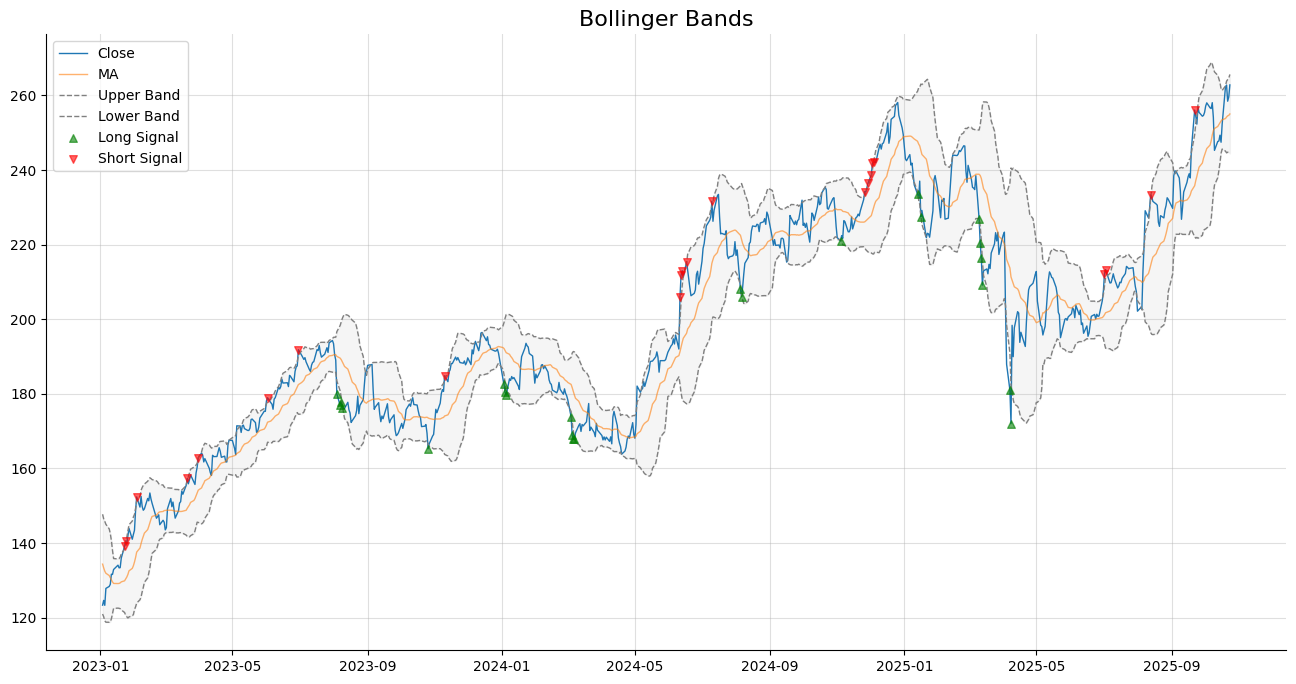

In [140]:
plot_bands(df.loc['2023':])

### RSI Plot

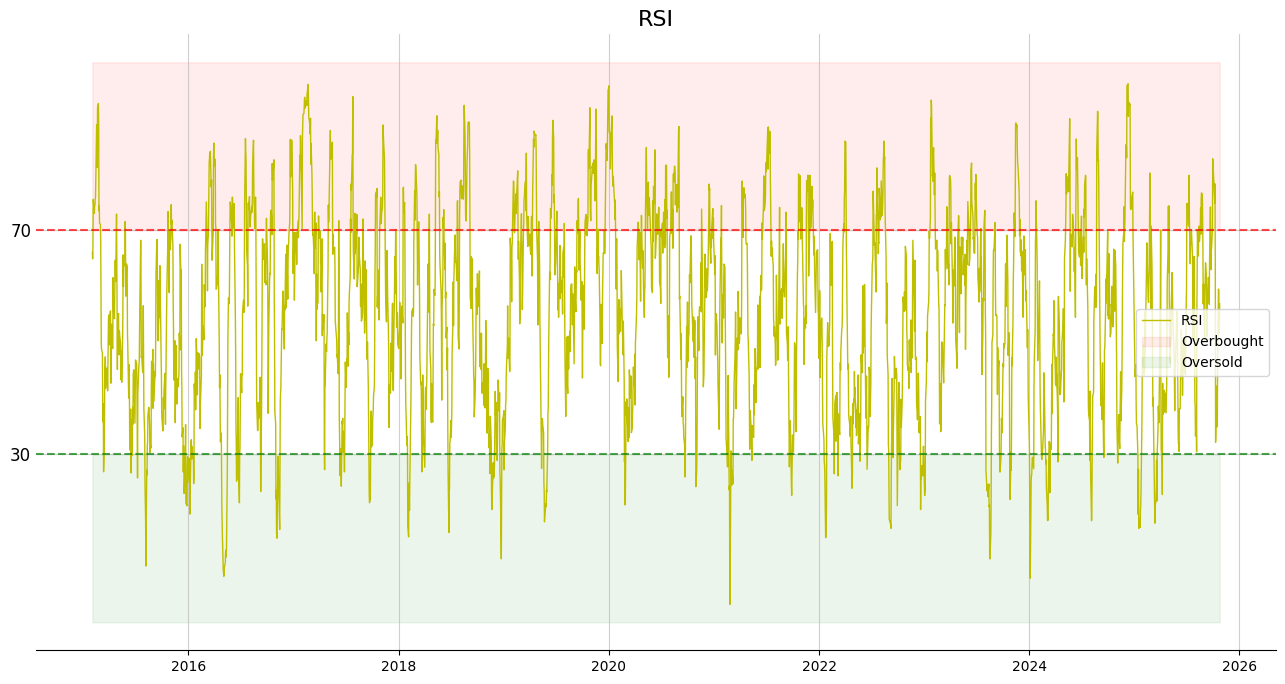

In [178]:
def plot_rsi(df):
    fig, ax = plt.subplots(figsize=(16,8))
    ax.set_title('RSI', fontsize=16)
    ax.plot(df['RSI'], label = 'RSI', linewidth=1, color='y')
    ax.axhline(70, color="r", linestyle="--", alpha=0.7)
    ax.axhline(30, color="g", linestyle="--", alpha=0.7)
    ax.fill_between(df.index, 70, 100, color='r', alpha=0.075, label='Overbought')
    ax.fill_between(df.index, 0, 30, color='g', alpha=0.075, label='Oversold')

    ax.grid(True, alpha=0.6)

    ax.spines[['top', 'right', 'left']].set_visible(False)
    ax.legend()
    ax.set_yticks([30,70])
    ax.tick_params(axis='y', labelsize=12, length=0)
    plt.show();

    return

plot_rsi(df)
